<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#load-and-research-data" data-toc-modified-id="load-and-research-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load and research data</a></span></li><li><span><a href="#make-dataset" data-toc-modified-id="make-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>make dataset</a></span></li><li><span><a href="#build-model" data-toc-modified-id="build-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>build model</a></span></li></ul></div>

In [25]:
import time
import pickle
import random
import librosa
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from scipy.io import wavfile

from keras.models import Sequential
from keras.layers import Activation, Conv1D, LSTM, Dense, LeakyReLU, Flatten, MaxPool1D, Dropout
from keras.utils import to_categorical

import matplotlib.pyplot as plt

# load and research data

In [2]:
df = pd.read_csv('./data/data_v_7_stc/meta/fold1_train.txt', sep='\t')

In [7]:
df.columns = ['filename', 'xz1', 'xz2', 'time', 'target']

In [52]:
df.head(1)

,filename,xz1,xz2,time,target
0,background_0001_time_stretch_1.wav,office,0.0,9.87941,background


In [4]:
df.shape

(9040, 5)

In [8]:
df[df['time'] > 1].shape

(8343, 5)

In [9]:
df[df['time'] < 1].shape

(696, 5)

In [10]:
df[df['time'] < 1]['target'].value_counts()

door        665
ring         16
keyboard     12
bags          3
Name: target, dtype: int64

In [11]:
df['target'].value_counts()

door             2732
tool             1327
knocking_door    1324
bags              988
keyboard          980
background        899
ring              570
speech            220
Name: target, dtype: int64

In [13]:
df[df['time'] > 1].groupby('target').sum()

,xz2,time
target,,
background,0.0,5111.431459
bags,0.0,5852.070551
door,0.0,4773.073604
keyboard,0.0,6271.668068
knocking_door,0.0,4615.728440
ring,0.0,7512.491750
speech,0.0,7890.544000
tool,0.0,5927.869500


In [50]:
df.head(1)

,filename,xz1,xz2,time,target
0,background_0001_time_stretch_1.wav,office,0.0,9.87941,background


In [20]:
data = wavfile.read('./data/data_v_7_stc/audio/background_0001_time_stretch_1.wav')

In [19]:
data[1].shape

(217841,)

In [18]:
217841 / 9.87941

22050.000961595884

In [21]:
data[0]

22050

In [31]:
f_list = []
for filename in df.sample(frac=1.)['filename'][:1000]:
    f, _ = wavfile.read('./data/data_v_7_stc/audio/' + filename)
    f_list.append(f)

In [32]:
Counter(f_list)

Counter({16000: 319, 22050: 681})

In [47]:
data, _ = librosa.load('./data/data_v_7_stc/audio/background_0001_time_stretch_1.wav', sr=8000)

In [48]:
data.shape

(79036,)

In [49]:
data.shape[0] / 9.87941

8000.072878846004

# make dataset

In [62]:
samples = []
targets = []
classes_count = {}

In [63]:
df.shape

(9040, 5)

In [64]:
t = time.time()
for row_no, row in df.iterrows():
    if row_no % 100 == 0:
        print(row_no, time.time() - t)
        t = time.time()
    filename = row['filename']
    filename = './data/data_v_7_stc/audio/' + filename
    data, rate = librosa.load(filename, sr=8000)
    target = row['target']
    for i in range(0, data.shape[0] - 8000, 8000):
        sample = data[i: i + 8000]
        if sample.shape[0] < 8000:
            continue
        samples.append(sample)
        targets.append(target)

0 0.0029802322387695312
100 13.604460000991821
200 10.432376146316528
300 12.205159187316895
400 9.318132877349854
500 9.786399841308594
600 13.35417890548706
700 9.998601913452148
800 7.6592137813568115
900 5.928725004196167
1000 9.92963194847107
1100 28.57975172996521
1200 28.391607761383057
1300 4.2213099002838135
1400 4.137710809707642
1500 4.126280307769775
1600 4.231290102005005
1700 4.425108909606934
1800 8.994123220443726
1900 6.002050161361694
2000 5.580780029296875
2100 4.1369171142578125
2200 6.405123710632324
2300 6.851844072341919
2400 5.117296934127808
2500 4.365433931350708
2600 3.8322370052337646
2700 3.0782787799835205
2800 5.446597099304199
2900 3.681962013244629
3000 3.264922857284546
3100 3.0600059032440186
3200 2.992868185043335
3300 2.5928452014923096
3400 2.470999002456665
3500 2.0350940227508545
3600 1.863011121749878
3700 1.6055638790130615
3800 1.594494342803955
3900 1.4082343578338623
4000 4.174235105514526
4100 4.5639989376068115
4200 6.300513744354248
4300 

In [65]:
Counter(targets)

Counter({'background': 4655,
         'bags': 5387,
         'door': 3853,
         'keyboard': 5783,
         'knocking_door': 3951,
         'ring': 7279,
         'speech': 7720,
         'tool': 4722})

In [67]:
target_dict = defaultdict(list)
for sample, target in zip(samples, targets):
    target_dict[target].append(sample)

In [70]:
with open('./data/samples_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(target_dict))

In [2]:
with open('./data/samples_8000.pkl', 'rb') as f:
    target_dict = pickle.loads(f.read())

In [3]:
target_list = list(target_dict.keys())
target_list.sort()

In [4]:
target2ind = {
    target: i
    for i, target in enumerate(target_list)
}

In [5]:
for target in target_dict.keys():
    random.shuffle(target_dict[target])

In [6]:
x, y = [], []
for target, samples in target_dict.items():
    target_ind = target2ind[target]
    for i in range(3500):
        x.append(samples[i])
        y.append(target_ind)

In [7]:
x = np.vstack(x)
y = np.array(y)

In [8]:
random_ind = list(range(len(y)))
random.shuffle(random_ind)

In [9]:
x = x[random_ind]
y = y[random_ind]

# build model

## experiment 1

In [19]:
model = Sequential()
model.add(Conv1D(16, 3, activation=LeakyReLU(), input_shape=(8000, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(32, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(128, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

/home/toly/projects/mipt_hack/env/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
x.shape

(28000, 8000)

In [22]:
history = model.fit(x.reshape(28000, 8000, 1), to_categorical(y), batch_size=32, epochs=10, validation_split=0.1)

Train on 25200 samples, validate on 2800 samples
Epoch 1/10
25200/25200 [==============================] - 47s 2ms/step - loss: 1.3451 - acc: 0.5026 - val_loss: 1.0858 - val_acc: 0.6243
Epoch 2/10
25200/25200 [==============================] - 46s 2ms/step - loss: 0.9421 - acc: 0.6795 - val_loss: 0.7886 - val_acc: 0.7404
Epoch 3/10
25200/25200 [==============================] - 50s 2ms/step - loss: 0.6850 - acc: 0.7762 - val_loss: 0.9774 - val_acc: 0.7057
Epoch 4/10
25200/25200 [==============================] - 47s 2ms/step - loss: 0.5404 - acc: 0.8235 - val_loss: 0.7942 - val_acc: 0.7643
Epoch 5/10
25200/25200 [==============================] - 46s 2ms/step - loss: 0.4842 - acc: 0.8448 - val_loss: 0.9007 - val_acc: 0.7679
Epoch 6/10
25200/25200 [==============================] - 46s 2ms/step - loss: 0.4166 - acc: 0.8695 - val_loss: 0.9231 - val_acc: 0.7721
Epoch 7/10
25200/25200 [==============================] - 46s 2ms/step - loss: 0.3912 - acc: 0.8805 - val_loss: 1.0585 - val_acc:

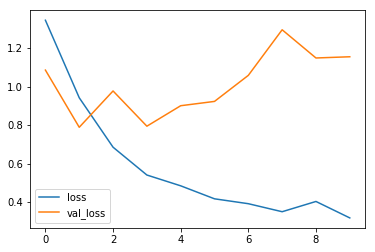

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

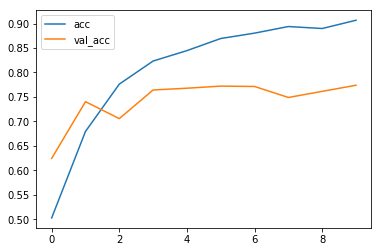

In [24]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## experiment 2

add dropout

In [31]:
model = Sequential()
model.add(Conv1D(16, 3, activation=LeakyReLU(), input_shape=(8000, 1)))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(128, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

/home/toly/projects/mipt_hack/env/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(x.reshape(28000, 8000, 1), to_categorical(y), batch_size=32, epochs=20, validation_split=0.1)

Train on 25200 samples, validate on 2800 samples
Epoch 1/10
25200/25200 [==============================] - 52s 2ms/step - loss: 1.3663 - acc: 0.4988 - val_loss: 1.1128 - val_acc: 0.6361
Epoch 2/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.9639 - acc: 0.6689 - val_loss: 0.9581 - val_acc: 0.6671
Epoch 3/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.7359 - acc: 0.7533 - val_loss: 0.8025 - val_acc: 0.7468
Epoch 4/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.6099 - acc: 0.8019 - val_loss: 0.7787 - val_acc: 0.7604
Epoch 5/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.5939 - acc: 0.8167 - val_loss: 0.7923 - val_acc: 0.7671
Epoch 6/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.4675 - acc: 0.8512 - val_loss: 0.9808 - val_acc: 0.7489
Epoch 7/10
25200/25200 [==============================] - 51s 2ms/step - loss: 0.4264 - acc: 0.8665 - val_loss: 1.4319 - val_acc:

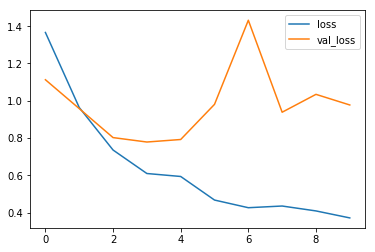

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

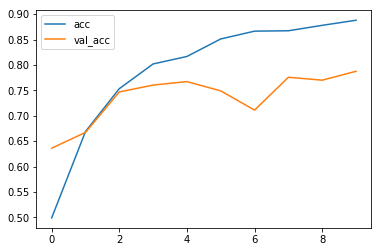

In [30]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## increase filters count

In [32]:
model = Sequential()
model.add(Conv1D(32, 3, activation=LeakyReLU(), input_shape=(8000, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(128, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(128, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

/home/toly/projects/mipt_hack/env/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(x.reshape(28000, 8000, 1), to_categorical(y), batch_size=32, epochs=20, validation_split=0.1)

Train on 25200 samples, validate on 2800 samples
Epoch 1/20
25200/25200 [==============================] - 71s 3ms/step - loss: 1.3387 - acc: 0.5059 - val_loss: 1.0065 - val_acc: 0.6596
Epoch 2/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.8915 - acc: 0.6985 - val_loss: 0.8469 - val_acc: 0.7243
Epoch 3/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.7185 - acc: 0.7685 - val_loss: 0.9124 - val_acc: 0.7364
Epoch 4/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.5727 - acc: 0.8178 - val_loss: 0.9359 - val_acc: 0.7332
Epoch 5/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.4766 - acc: 0.8506 - val_loss: 0.8515 - val_acc: 0.7679
Epoch 6/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.4387 - acc: 0.8662 - val_loss: 0.9434 - val_acc: 0.7739
Epoch 7/20
25200/25200 [==============================] - 70s 3ms/step - loss: 0.4041 - acc: 0.8792 - val_loss: 0.9453 - val_acc:

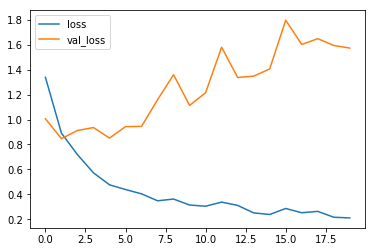

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

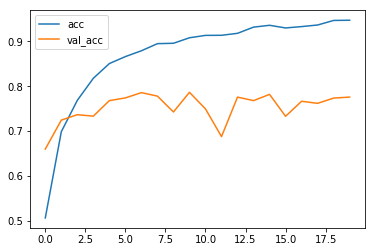

In [36]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## increase batch

In [56]:
model = Sequential()
model.add(Conv1D(64, 3, activation=LeakyReLU(), input_shape=(8000, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(2))
model.add(Conv1D(64, 3, activation=LeakyReLU()))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

/home/toly/projects/mipt_hack/env/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x.reshape(28000, 8000, 1), to_categorical(y), batch_size=32, epochs=20, validation_split=0.1)

Train on 25200 samples, validate on 2800 samples
Epoch 1/20


In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()